# Import der notwendigen Bibliotheken

Zunächst werden alle für den Code notwendigen Pakete importiert.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict

from torch.autograd import Variable
from PIL import Image
import PIL

from torch.optim import lr_scheduler
import copy

import json
import os
from os.path import exists

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Laden der Daten

Hier werden die Bilddaten mithilfe des Torchvisionpakets geladen. Der Datensatz ist in zwei Teile gegliedert: Training und Validierung. Für das Training werden Transformationen wie zufällige Skalierung, Zuschneiden und Spiegeln angewendet. Dies wird dem Netzwerk helfen, sich zu verallgemeinern und zu einer besseren Leistung führen. Es muss außerdem sichergestellt werden, dass die Eingangsdaten auf 224x224 Pixel skaliert werden, wie von dem später verwendeten Netzwerk gefordert.

Das Validierungsset wird verwendet, um die Leistung des Modells anhand von Daten zu messen, die es noch nicht gesehen hat. Dazu benötigen man keine Skalierung oder Rotationstransformationen, aber die Größe der Bilder muss richtig zugeschnitten werden.

Die von torchvision verfügbaren vortrainierten Netzwerke wurden auf den ImageNet-Datensatz geschult, wobei jeder Farbkanal separat normiert wurde. Für beide Sets müssen die Mittelwerte und Standardabweichungen der Bilder auf das normalisiert werden, was das Netzwerk erwartet. Für die Mittelwerte ist es [0.485, 0.456, 0.406] und für die Standardabweichungen[0.229, 0.224, 0.225]- berechnet aus den ImageNet-Bildern. Diese Werte verschieben jeden zu zentrierenden Farbkanal um 0 und reichen von -1 bis 1.

In [2]:
data_dir = 'C:/Users/Christian/Programming/Pytorch/Final Project/flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
nThreads = 4
batch_size = 32
use_gpu = torch.cuda.is_available()

In [3]:
# Transformation der Bilder 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Laden des Datensatzes
data_dir = 'flower_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}

# Definieren des dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

class_names = image_datasets['train'].classes

 # Label Mapping

Hier wird eine Zuordnung von Kategorienbezeichnung zu Kategoriename geladen. Diese befindet sich in der Datei cat_to_name.json. Es ist ein JSON-Objekt, das mit dem json-Modul eingelesen werden kann. Dies enthält eine Zuordnung von Zahlen zu den tatsächlichen Namen der Pflanzen.

In [4]:
import json

classes = json.loads('{"21": "fire lily", "3": "canterbury bells", "45": "bolero deep blue", "1": "pink primrose", "34": "mexican aster", "27": "prince of wales feathers", "7": "moon orchid", "16": "globe-flower", "25": "grape hyacinth", "26": "corn poppy", "79": "toad lily", "39": "siam tulip", "24": "red ginger", "67": "spring crocus", "35": "alpine sea holly", "32": "garden phlox", "10": "globe thistle", "6": "tiger lily", "93": "ball moss", "33": "love in the mist", "9": "monkshood", "102": "blackberry lily", "14": "spear thistle", "19": "balloon flower", "100": "blanket flower", "13": "king protea", "49": "oxeye daisy", "15": "yellow iris", "61": "cautleya spicata", "31": "carnation", "64": "silverbush", "68": "bearded iris", "63": "black-eyed susan", "69": "windflower", "62": "japanese anemone", "20": "giant white arum lily", "38": "great masterwort", "4": "sweet pea", "86": "tree mallow", "101": "trumpet creeper", "42": "daffodil", "22": "pincushion flower", "2": "hard-leaved pocket orchid", "54": "sunflower", "66": "osteospermum", "70": "tree poppy", "85": "desert-rose", "99": "bromelia", "87": "magnolia", "5": "english marigold", "92": "bee balm", "28": "stemless gentian", "97": "mallow", "57": "gaura", "40": "lenten rose", "47": "marigold", "59": "orange dahlia", "48": "buttercup", "55": "pelargonium", "36": "ruby-lipped cattleya", "91": "hippeastrum", "29": "artichoke", "71": "gazania", "90": "canna lily", "18": "peruvian lily", "98": "mexican petunia", "8": "bird of paradise", "30": "sweet william", "17": "purple coneflower", "52": "wild pansy", "84": "columbine", "12": "colts foot", "11": "snapdragon", "96": "camellia", "23": "fritillary", "50": "common dandelion", "44": "poinsettia", "53": "primula", "72": "azalea", "65": "californian poppy", "80": "anthurium", "76": "morning glory", "37": "cape flower", "56": "bishop of llandaff", "60": "pink-yellow dahlia", "82": "clematis", "58": "geranium", "75": "thorn apple", "41": "barbeton daisy", "95": "bougainvillea", "43": "sword lily", "83": "hibiscus", "78": "lotus lotus", "88": "cyclamen", "94": "foxglove", "81": "frangipani", "74": "rose", "89": "watercress", "73": "water lily", "46": "wallflower", "77": "passion flower", "51": "petunia"}')


# Laden des Checkpoints

An dieser Stelle wird eine Funktion geschrieben, die einen Checkpoint laden und das Modell neu aufbauen kann. Auf diese Weise kann auf trainierte Netzwerke zurückgekommen und weiter daran gearbeitet werden.

In [5]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = models.resnet18()
    
    # Die input_size entspricht den in_features des vortrainierten Modells.
    input_size = 512
    output_size = 102
    
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(512, 256)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(256, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))


    # Austausch des vortrainierten Modellklassifikators durch den eigenen Klassifikator
    model.fc = classifier
    
    
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, checkpoint['class_to_idx']

# Index der jeweiligen Klasse zuordnen
loaded_model, class_to_idx = load_checkpoint('classifier270v2.pth')
idx_to_class = { v : k for k,v in class_to_idx.items()}

# Die Klassifizierung (Inference)

Hier geht es um eine Funktion, welche die schlussendliche Klassifizierung vornimmt. Das heißt, es wird ein Bild an das Netzwerk  übergeben und dieses prognostiziert die Klasse der Blume im Bild. Die Funktion namens predict, nimmt ein Bild und ein Modell auf und gibt dann die Klassen mit den höchsten Wahrscheinlichkeiten zurück. 

Zunächst musst aber die Verarbeitung des Eingangsbildes so gehandhabt werden, dass es in dem Netzwerk verwendet werden kann.

# Bildvorverarbeitung

Es ist am besten, eine Funktion zu schreiben, die das Bild vorverarbeitet, damit es als Input für das Modell verwendet werden kann. Diese Funktion sollte die Bilder in der gleichen Weise verarbeiten wie beim Training.

Zuerst muss die Größe der Bilder geändert werden. Dann müssen die Bilder auf die mittleren 223x224 Pixel zugeschnitten werden.

Farbkanäle von Bildern werden typischerweise als ganze Zahlen 0-255 kodiert. Das Modell erwartet aber Zahlen im Bereich von 0 bis 1. Die Werte müssen also umgerechnet werden. Am einfachsten ist es mit einem Numpy-Array, das man aus einem PIL-Bild wie np_image = np.array(pil_image) erhalten kann.

Wie bisher erwartet das Netzwerk, dass die Bilder auf eine bestimmte Weise normalisiert werden. Für den Mittelwert ist es[0.485, 0.456, 0.406] und für die Standardabweichungen[0.229, 0.224, 0.225]. Der Mittelwert wird von jedem Farbkanal substrahiert und dann durch die Standardabweichung dividiert.

Und schließlich erwartet PyTorch, dass sich der Farbkanal in der erste Dimension befindet. Die Dimensionen werden mit ndarray.transpose also neu angeordnen. Der Farbkanal muss an erster Stelle stehen und die Reihenfolge der anderen beiden Dimensionen beibehalten.


In [6]:
#Skalieren, beschneiden und normalisieren eines PIL-Bildes für ein PyTorch-Modell um ein Numpy-Array auszugeben.
def process_image(image):
      
    size = 256, 256
    image.thumbnail(size, Image.ANTIALIAS)
    image = image.crop((128 - 112, 128 - 112, 128 + 112, 128 + 112))
    npImage = np.array(image)
    npImage = npImage/255.
        
    imgA = npImage[:,:,0]
    imgB = npImage[:,:,1]
    imgC = npImage[:,:,2]
    
    imgA = (imgA - 0.485)/(0.229) 
    imgB = (imgB - 0.456)/(0.224)
    imgC = (imgC - 0.406)/(0.225)
        
    npImage[:,:,0] = imgA
    npImage[:,:,1] = imgB
    npImage[:,:,2] = imgC
    
    npImage = np.transpose(npImage, (2,0,1))
    
    return npImage

In [7]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch-Tensoren gehen davon aus, dass der Farbkanal in der erste Dimension ist. Matplotlib hingegen nimmt ihn in der dritten Dimension an.
    image = image.numpy().transpose((1, 2, 0))
    
    # Preprocessing rückgängig machen
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Das Bild muss zwischen 0 und 1 abgeschnitten werden oder es würde bei der Anzeige wie Rauschen aussehen.
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

# Die Klassifizierung

In diesem Abschnitt befindet sich eine Funktion zum Erstellen von Vorhersagen mit Hilfe des erstellten Modells. Eine gängige Praxis ist es, die Top 5 der wahrscheinlichsten Klassen vorherzusagen. 

Um die 5 größten Werte in einem Tensor zu erhalten wird x.topk(k) verwendet. Diese Methode liefert sowohl die höchsten 5-Wahrscheinlichkeiten als auch die Indizes derjenigen Wahrscheinlichkeiten, die den Klassen entsprechen. Zusätzlich müssen diese Indizes zu den eigentlichen Klassenbeschriftungen mit class_to_idx konvertiert werden. 

In [8]:
# Vorhersage der Klasse einer Bilddatei
def predict(image_path, model, topk=5):
     
   
    image = torch.FloatTensor([process_image(Image.open(image_path))])
    model.eval()
    output = model.forward(Variable(image))
    pobabilities = torch.exp(output).data.numpy()[0]
    

    top_idx = np.argsort(pobabilities)[-topk:][::-1] 
    top_class = [idx_to_class[x] for x in top_idx]
    top_probability = pobabilities[top_idx]

    return top_probability, top_class

In [9]:
print (predict('flower_data/valid/17/image_03837.jpg', loaded_model))

(array([0.40358865, 0.05953344, 0.04168273, 0.04002387, 0.02952235],
      dtype=float32), ['17', '66', '71', '100', '41'])


# Plausibilitätsprüfung

Selbst wenn die Validierungsgenauigkeit hoch ist, ist es immer gut zu überprüfen, ob es keine offensichtlichen Fehler gibt. Hier wird matplotlib verwendet, um die Wahrscheinlichkeiten für die Top 5 Klassen als Balkendiagramm zusammen mit dem Eingabebild darzustellen. 
Um einen PyTorch-Tensor als Bild darzustellen, wird die imshow-Funktion verwendet.


In [10]:
# Anzeigen eines Bildes mit und dessen 5 wahrscheinlichsten Klassen.
def view_classify(img, probabilities, classes, mapper):
    
    img_filename = img.split('/')[-2]
    img = Image.open(img)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    flower_name = mapper[img_filename]
    
    ax1.set_title(flower_name)
    ax1.imshow(img)
    ax1.axis('off')
    
    y_pos = np.arange(len(probabilities))
    ax2.barh(y_pos, probabilities)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([mapper[x] for x in classes])
    ax2.invert_yaxis()

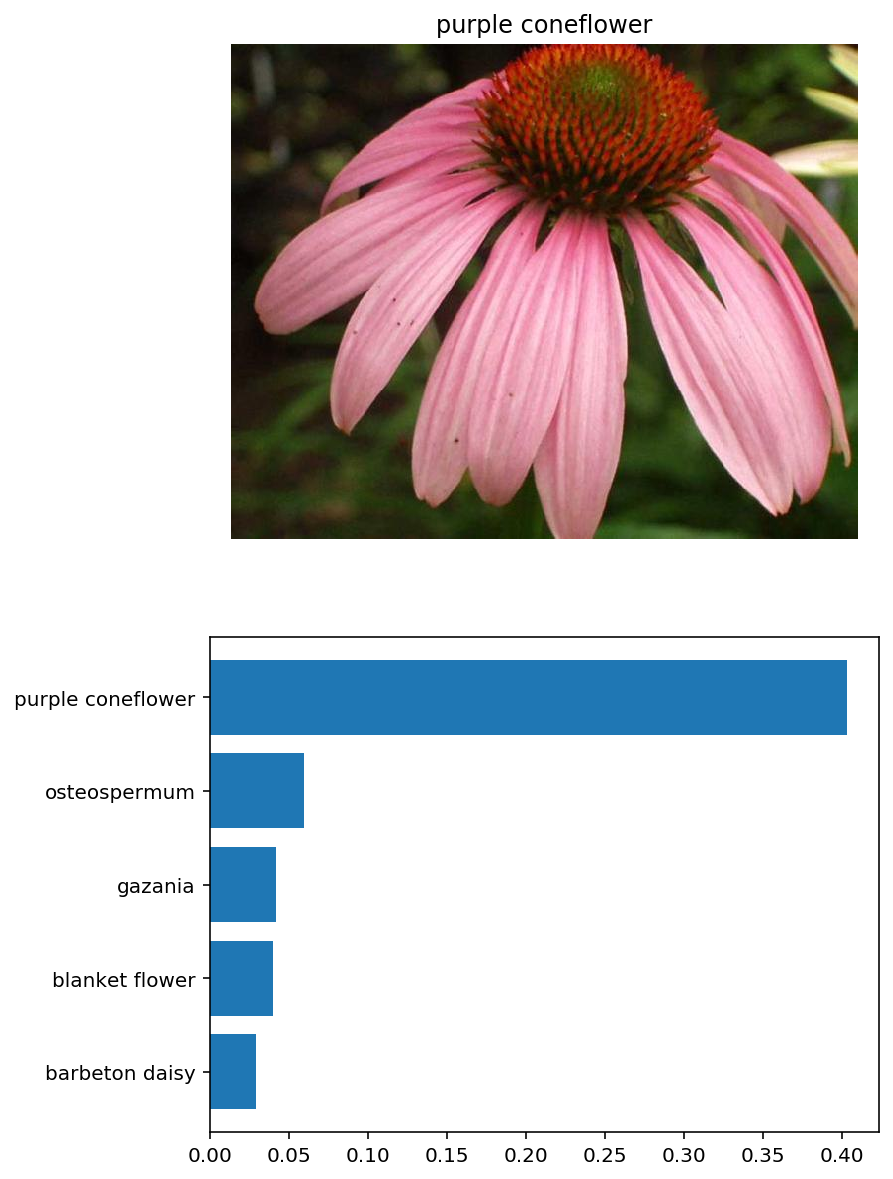

In [11]:
img = 'flower_data/valid/17/image_03837.jpg'
p, c = predict(img, loaded_model)
view_classify(img, p, c, classes)